# **Import Libraries**

In [180]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import gensim

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from tensorflow.keras import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Embedding, Flatten, concatenate
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import RandomNormal, HeNormal, GlorotNormal
from tensorflow.keras.utils import to_categorical

Insight : Melakukan `import` pada `library-library` yang dibutuhkan untuk
`analisis` dan `pemodelan` data pada `deep learning`.

# **Data Loading**

In [181]:
train = pd.read_csv("emotion-labels-train.csv")
val = pd.read_csv("emotion-labels-val.csv")
test = pd.read_csv("emotion-labels-test.csv")

Insight : Untuk csv file pada `train, val, dan test`, digunakan `pd.read_csv` untuk `mengubah` `csv` ke dalam bentuk `dataframe`

# **Exploratory Data Analysis (EDA)**

In [182]:
df = pd.concat([train , val , test] , axis = 0)
df = df.sample(frac=1).reset_index(drop = True)
df.head()

,text,label
0,Mary Berry and her reign of terror,fear
1,Rewatching 'Raising Hope' (with hubs this time...,joy
2,Said it before and I'll say it now: America is...,anger
3,@BuzzFeed so this houses will get into my inst...,fear
4,That boy so intimidated he go back and say dum...,fear


Insight : Melakukan `concat` pada `train, val, dan test` yang dibutuhkan untuk menggabungkan ketiga dataframe dan dilakukan `pengacakan` menggunakan fungsi `sample` dan diatur ulang indeksnya menggunakan `reset_index`. `Pengacakan` ini berguna `mengurangi bias` pada saat `pelatihan model`.

In [183]:
df.shape

(7102, 2)

Insight : Mengecek ukuran dataframe menggunakan fungsi `shape`. Pada hasil, terlihat bahwa pada row memiliki `7102` data dan pada column memiliki `2` buah.

In [184]:
df.label.value_counts()

label
fear       2252
anger      1701
joy        1616
sadness    1533
Name: count, dtype: int64

Insight : Menghitung jumlah data setiap label menggunakan `value_counts`. Terlihat bahwa yang terbanyak adalah `fear` sebanyak `2252` data.

In [185]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7102 entries, 0 to 7101
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7102 non-null   object
 1   label   7102 non-null   object
dtypes: object(2)
memory usage: 111.1+ KB


Insight : Mengecek `seluruh informasi` pada `dataframe` menggunakan fungsi `info`. Pada hasil, terlihat bahwa `seluruh kolom` merupakan `string`.

In [186]:
df.isnull().sum()

text     0
label    0
dtype: int64

Insight : Mengecek `missing values` menggunakan fungsi `isnull` beserta `sum` untuk `menjumlahkan` hasil isnull tersebut. Pada hasil, terlihat bahwa seluruh kolom `tidak` memiliki `missing values`.

In [187]:
df.duplicated().sum()

0

Insight : Mengecek `duplikasi` data terlebih dahulu menggunakan fungsi `duplicated` dibarengi dengan `sum` untuk `menjumlahkan` total `duplikasinya`. Pada hasil, `duplikasi` data adalah 0 alias `tidak ada`.

In [188]:
df.text.str.isspace().sum()

0

Insight : Mengecek `baris kosong` pada kolom `text` menggunakan fungsi `str.isspace` dibarengi dengan `sum` untuk `menjumlahkan` total `baris kosongnya`. Pada hasil, `baris kosong` pdaa kolom text adalah 0 alias `tidak ada`.

In [189]:
df.describe()

,text,label
count,7102,7102
unique,6908,4
top,@iTriborg — make him feel vigorous. 'Fine. You...,fear
freq,3,2252


Insight : Melihat perhitungan pada setiap kolom menggunakan fungsi `describe`. Dan yang muncul adalah perhitungan `count, unique, top, dan freq`.

Text(0.5, 1.0, 'Word Cloud Of Text')

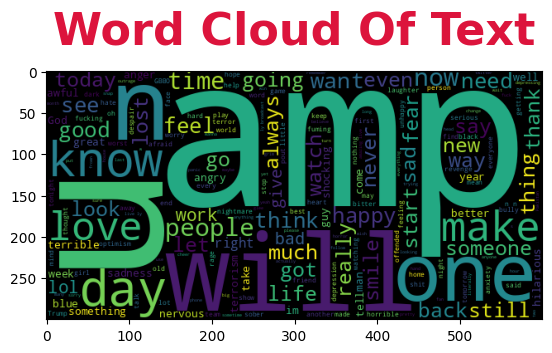

In [190]:
wc = WordCloud(width=600 , height = 300 , random_state = 101).generate(' '.join(df.text))
plt.imshow(wc)
plt.title('Word Cloud Of Text' , fontsize = 32 , fontweight = 'bold' , color = 'crimson' , pad = 20)

Insight : Menggunakan `WorldCloud` untuk menampilkan `gambaran banyaknya tiap value` pada kolom `text` yang digunakan pula fungsi `join` untuk `menggabungkan keseluruhan teks` pada text. Untuk menampilkan gambarannya juga digunakan `matplotlib` dengan berbagai parameter untuk menentukan hal teknis gambarannya.

In [191]:
df['text-len'] = df.text.apply(len)

Insight : Menambahkan kolom baru untuk `panjang` dari `string` pada kolom text menggunakan `len` dan kemudian didefinisikan kolomnya menggunakan `df['text-len']`.

In [192]:
df.head()

,text,label,text-len
0,Mary Berry and her reign of terror,fear,34
1,Rewatching 'Raising Hope' (with hubs this time...,joy,98
2,Said it before and I'll say it now: America is...,anger,117
3,@BuzzFeed so this houses will get into my inst...,fear,95
4,That boy so intimidated he go back and say dum...,fear,105


Insight : Melihat `5 data pertama` pada dataframe menggunakan fungsi `head`.

In [193]:
df.shape

(7102, 3)

Insight : Melihat kembali ukuran dataframe menggunalan fungsi `shape`. Terlihat bahwa ukuran pada column telah berubaha dari 2 menjadi 3.

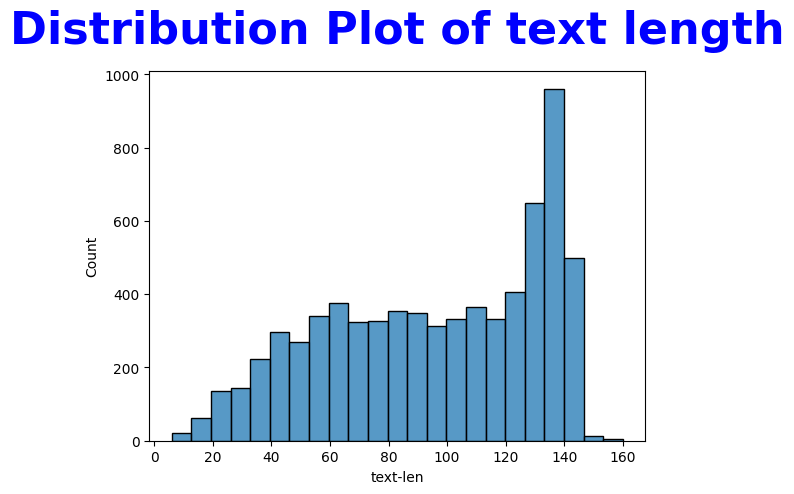

In [194]:
sns.histplot(df['text-len'])
plt.title('Distribution Plot of text length', fontsize = 32 , color = 'blue' , fontweight = 'bold' , pad = 20);

Insight : Melihat `histogram` pada `text-len` menggunakan `seaborn dan matplotlib`. Terlihat bahwa pada `histogram`, string yang memiliki panjang `130-an` itu hampir mencapai `1000` data.

<Axes: xlabel='label', ylabel='count'>

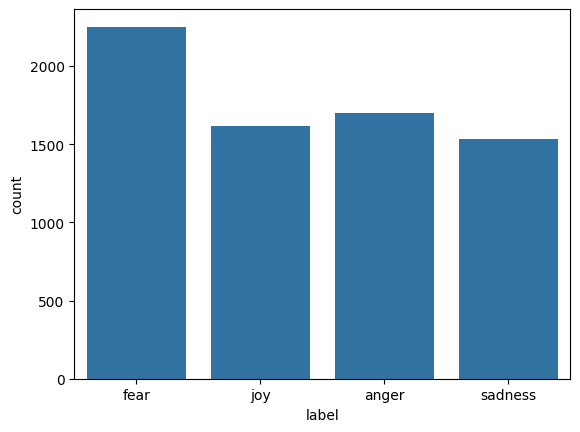

In [195]:
sns.countplot(df , x='label')

Insight : Menampilkan banyaknya data pada label menggunakan `countplot` pada `seaborn`. Terlihat label `fear` lebih banyak dibanding label yang lainnya.

# **Feature Engineering**

In [196]:
# Splitting between `X` and `y`

X_train = train['text']
y_train = train['label']
X_val = val['text']
y_val = val['label']
X_test = test['text']
y_test = test['label']

Insight : Melakukan `definisi` X dan y, untuk kolom `text` itu `X`, dan `label` itu `y`.

In [197]:
# Download stopwords
nltk.download('punkt')
nltk.download('stopwords')

# List stopwords
stop_words = set(stopwords.words('english'))

# Fungsi untuk melakukan preprocessing
def preprocess_text(text):
    # Normalisasi teks
    text = text.lower()
    text = re.sub(r"i'm", 'i am', text)
    text = re.sub(r"im", 'i am', text)
    text = re.sub(r"you're", 'you are', text)

    # Pembersihan teks
    text = re.sub(r'http\S+', '', text)  # Menghapus URL
    text = re.sub(r'@\w+', '', text)     # Menghapus handles
    text = re.sub(r'#\w+', '', text)     # Menghapus coded values
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Hapus karakter khusus

    # Tokenisasi teks
    tokens = word_tokenize(text)

    # Menghapus stopwords
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # Penggabungan kembali kata-kata
    processed_text = ' '.join(filtered_tokens)
    return processed_text

# Proses preprocessing untuk semua data X_train
X_train_preprocessed = X_train.apply(preprocess_text)
X_val_preprocessed = X_val.apply(preprocess_text)
X_test_preprocessed = X_test.apply(preprocess_text)

# Print hasil preprocessing
for i, (train_text, val_text, test_text) in enumerate(zip(X_train_preprocessed, X_val_preprocessed, X_test_preprocessed)):
    print(f"Preprocessed text {i + 1} (Train): {train_text}")
    print(f"Preprocessed text {i + 1} (Val): {val_text}")
    print(f"Preprocessed text {i + 1} (Test): {test_text}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Preprocessed text 1 (Train): got back seeing burslem amazing face still hurts laughing much
Preprocessed text 1 (Val): lol thought maybe couldnt decide levity
Preprocessed text 1 (Test): must knowing means adj happy cheerful
Preprocessed text 2 (Train): oh dear evening absolute hilarity dont think laughed much long ti ame
Preprocessed text 2 (Val): nawaz sharif getting funnier day day
Preprocessed text 2 (Test): old saying shared one gained another day
Preprocessed text 3 (Train): waiting week game
Preprocessed text 3 (Val): nawaz sharif getting funnier day day
Preprocessed text 3 (Test): bridget jones baby bloody hilarious
Preprocessed text 4 (Train): thank much gloria sweet thoughtful made day joyful love
Preprocessed text 4 (Val): ill people watch enjoy rare show opti amism
Preprocessed text 4 (Test): sparkling water makes life sparkly
Preprocessed text 5 (Train): feel blessed work family nanny nothing love amp appreciation makes smile
Preprocessed text 5 (Val): love family much
Pre

Insight : Pertama, import library `NLTK` untuk mengakses `pemrosesan teks`. Kemudian download `stopwords`. Stopwords ini berfungsi untuk `mengabaikan` kata yang sering muncul pada saat pemrosesan teks. Kemudian dilakukan preprocessing dengan cara `normalisasi dan pembersihan teks`. Dan kata-kata yang bukan stopwords akan `digabung` kembali. Lalu hasil `preprocessing` disimpan pada variabel `X_train_preprocessed`, `X_val_preprocessed`, dan `X_test_preprocessed`. Terakhir hasilnya `dicetak` dan mengeluarkan `output` seperti di atas. Terlihat kata-kata pada kolom `text` sudah `bersih`.

In [198]:
# Combine preprocessed text from all datasets
all_texts = pd.concat([X_train_preprocessed, X_val_preprocessed, X_test_preprocessed], axis=0)

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_texts)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

Insight : Pertama menggabungkan seluruh `preprocessing` pada `X` tadi menggunakan `pd.concat`. Kemudian penggabungan ini `ditokenisasi` menggunakan `Tokenizer` untuk mengonversi teks menjadi urutan indeks token. Dan `fit_on_texts` digunakan untuk membangun kosakata berdasarkan teks yang ada. Sedangkan `texts_to_sequences` mengonversi kembali teks menjadi urutan indeks token.

In [199]:
# Train Word2Vec model
tokenized_texts = [word_tokenize(text) for text in all_texts]
word2vec_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=1, workers=4)

# Get word vector for a specific word
word_vector = word2vec_model.wv['word']

print("Word embedding for 'word':")
print(word_vector)

Word embedding for 'word':
[-0.00720699  0.00405848  0.01024977 -0.00457258  0.01326305 -0.05759205
  0.00178656  0.0595123  -0.01868503 -0.01753596 -0.01996654 -0.0404053
 -0.00313128  0.02284098  0.0036337  -0.01960721  0.02121158 -0.04071656
 -0.00280904 -0.05561679  0.01042103  0.01286107  0.00992552 -0.0108606
 -0.00521779 -0.0051266  -0.02195987 -0.00662163 -0.03052442 -0.00659336
  0.02455887  0.01016776 -0.00266419 -0.01893966 -0.01612199  0.04048857
  0.00019618 -0.02321058 -0.0312625  -0.06271455 -0.00063379 -0.02582066
 -0.01852946  0.00040919  0.00301142 -0.01302781 -0.02264532 -0.00212823
  0.005429    0.0250428   0.01045715 -0.0306396  -0.01581876 -0.00151058
 -0.01838556  0.02219794  0.00957769  0.00245217 -0.02671483  0.00999706
  0.01075036  0.01525111 -0.01137873 -0.00733211 -0.02574391  0.01500459
  0.01093369  0.00772012 -0.03696896  0.01293524 -0.01159272  0.02050108
  0.02756242 -0.01243099  0.02590089  0.00929973 -0.00765859  0.00392258
 -0.02959404  0.02257654 -

Insight : Lalu model `Word2Vec` dibuat dengan menggunakan teks-teks yang telah ditokenisasi sebagai `input` guna menghasilkan `representasi vektor` kata-kata dalam `ruang vektor` yang memiliki `dimensi 100`. Model ini menggunakan parameter `window`, `minimum count`, dan `workers` untuk pelatihannya. Terakhir vektor `diekstraksi` dan dicetak sebagai `output` yang terlihat seperti di atas.

In [200]:
# Padding sequences
maxlen = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=maxlen, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post')

# Encode, Fit, and Transform for y
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

Insight : Dilakukan `encoding` menggunakan `LabelEncoder` untuk mengganti teks pada kelas label menjadi dalam bentuk bilangan bulat. Lalu diterapkan pada train, val, dan test.

In [201]:
input_dim = len(tokenizer.word_index) + 1
output_dim = len(word_vector)
num_classes = len(label_encoder.classes_)

Insight : Membuat `variabel` baru yang `menghtiung panjang` yang digunakan fungsi `len` pada input_dim, output_dim, dan num_classes untuk kebutuhan pemodelan.

# **ANN Training (Sequential API/Functional API)**

## Sequential API

In [202]:
# Clear session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

Insight : `Clear session` berguna untuk memastikan bahwa tidak ada yang menggunakan `state sebelumnya` pada pemodelan dengan cara dibersihkan guna `tidak mempengaruhi` pemodelan baru.

In [203]:
# Create callback
callback_1 = [
    EarlyStopping(monitor = 'val_loss',
                  patience = 10,
                  restore_best_weights=True)
]

Insight : `Early stopping` berguna untuk menghentikan pelatihan lebih awal, jika terjadi peningkatan metrik `val_loss`. Dan patience diatur 10 guna memantau `val_loss` setelah 10 `epochs`. Dan untuk `restore_best_weights=True` berguna mengembalikan weights ke iterasi terbaik pada pelatihan agar terhindar dari `overfitting`.

### vi.1. Model Definition

In [204]:
# Create sequential API

model_sequential = Sequential()
model_sequential.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=maxlen))
model_sequential.add(Flatten())
model_sequential.add(Dense(128,
                           activation='relu',
                           kernel_initializer=tf.keras.initializers.HeNormal(seed),
                           input_shape=(input_dim,)))
model_sequential.add(Dense(64,
                           activation='relu',
                           kernel_initializer=tf.keras.initializers.HeNormal(seed)))
model_sequential.add(Dense(num_classes,
                           activation='softmax',
                           kernel_initializer=tf.keras.initializers.GlorotNormal(seed)))

# Compile
model_sequential.compile(loss='sparse_categorical_crossentropy',
                         optimizer='adam',
                         metrics=['accuracy'])
model_sequential.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1122400   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 128)               1280128   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
Total params: 2411044 (9.20 MB)
Trainable params: 2411044 (9.20 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Insight : Pada `training sequential api` digunakan neuron `128` dan `64`. Terlebih dahulu melakukan `embedding` dan `flatten` pada `vektor`.

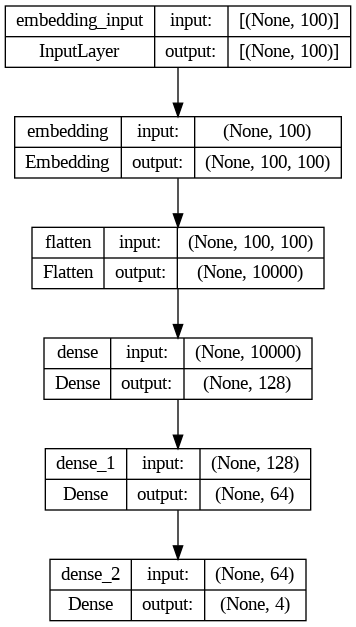

In [205]:
# Plot layers

tf.keras.utils.plot_model(model_sequential, show_shapes=True)

Insight : Merupakan gambaran `struktur` sequential api pada training.

### vi.2. Model Training

In [206]:
# Train the model

%%time
history_sequential = model_sequential.fit(X_train_pad,
                                          y_train_encoded,
                                          epochs=50,
                                          callbacks=callback_1,
                                          validation_data=(X_val_pad, y_val_encoded),
                                          batch_size=32)

Epoch 1/50
113/113 [==============================] - 5s 36ms/step - loss: 1.3757 - accuracy: 0.3133 - val_loss: 1.3596 - val_accuracy: 0.3199
Epoch 2/50
113/113 [==============================] - 5s 40ms/step - loss: 0.8249 - accuracy: 0.7418 - val_loss: 0.8849 - val_accuracy: 0.6513
Epoch 3/50
113/113 [==============================] - 4s 34ms/step - loss: 0.1374 - accuracy: 0.9651 - val_loss: 0.8284 - val_accuracy: 0.6830
Epoch 4/50
113/113 [==============================] - 4s 33ms/step - loss: 0.0754 - accuracy: 0.9773 - val_loss: 0.8573 - val_accuracy: 0.6916
Epoch 5/50
113/113 [==============================] - 4s 38ms/step - loss: 0.0575 - accuracy: 0.9801 - val_loss: 0.8535 - val_accuracy: 0.7147
Epoch 6/50
113/113 [==============================] - 4s 36ms/step - loss: 0.0521 - accuracy: 0.9784 - val_loss: 0.9538 - val_accuracy: 0.6859
Epoch 7/50
113/113 [==============================] - 4s 34ms/step - loss: 0.0469 - accuracy: 0.9812 - val_loss: 0.8729 - val_accuracy: 0.7262

Insight : Disini digunakan `callback` untuk `menghentikan` proses `training` dengan `memantau` `val_loss`. Dan pada `sequential api training` digunakan `epochs` sebanyak `50` dan `batch_size` sebesar `32`.

### vi.3. Model Evaluation

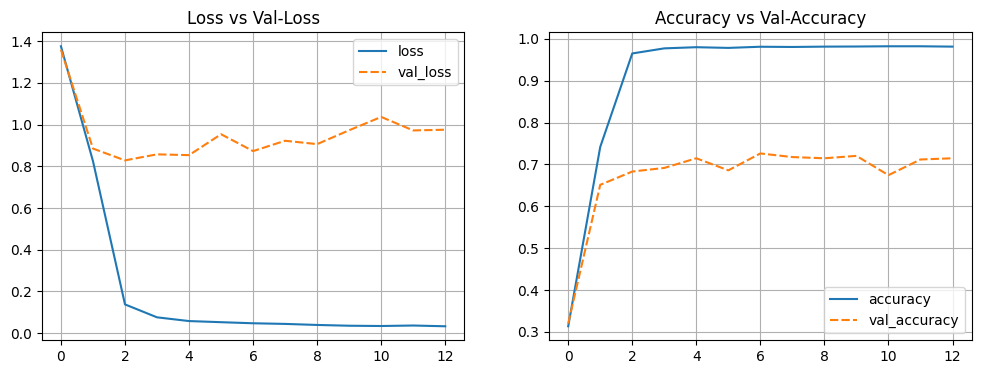

In [207]:
# Plot training results

history_sequential_df = pd.DataFrame(history_sequential.history)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_sequential_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_sequential_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

Insight : Terlihat cukup `baik` terkait `fitting` pada `val` dan juga `accuracy`.

In [208]:
# Predict test-set

y_pred_sequential = model_sequential.predict(X_test_pad)

99/99 [==============================] - 1s 5ms/step


Insight: Melakukan `predict` untuk kemudian dievaluasi.

In [209]:
# Model Evaluation (test-set)

roc_auc_s = roc_auc_score(y_test_encoded, y_pred_sequential, multi_class='ovr')
print("ROC-AUC Score:", roc_auc_s)

ROC-AUC Score: 0.8856719555694446


Insight : Pada skor `ROC-AUC`, cukup tinggi untuk `sequential api training` yaitu sebesar `89%` jika dibulatkan.

## Functional API

In [210]:
# Clear session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

### vi.1. Model Definition

In [211]:
input_layer = Input(shape=(maxlen,))
embedding_layer = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=maxlen)(input_layer)
flatten_layer = Flatten()(embedding_layer)
hidden_layer_1 = Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed)) (flatten_layer)
hidden_layer_2 = Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed)) (hidden_layer_1)
hidden_layer_3 = Dense(32, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed)) (hidden_layer_2)

concat_layer = concatenate([flatten_layer, hidden_layer_3])
output_layer = Dense(num_classes, activation='softmax') (concat_layer)

model_functional = Model(inputs=input_layer, outputs=output_layer)

# Compile
model_functional.compile(loss='sparse_categorical_crossentropy',
                         optimizer='adam',
                         metrics='accuracy')
model_functional.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 100, 100)             1122400   ['input_1[0][0]']             
                                                                                                  
 flatten (Flatten)           (None, 10000)                0         ['embedding[0][0]']           
                                                                                                  
 dense (Dense)               (None, 128)                  1280128   ['flatten[0][0]']             
                                                                                              

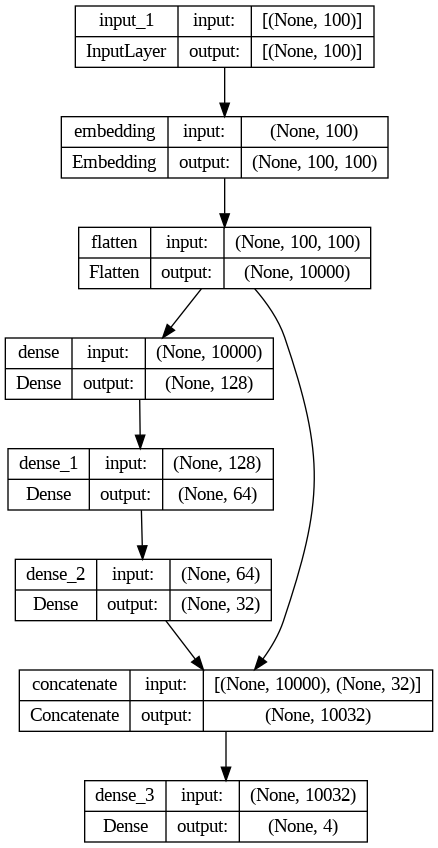

In [212]:
# Plot layers

tf.keras.utils.plot_model(model_functional, show_shapes=True)

### vi.2. Model Training

In [213]:
# Train the model

%%time
history_functional = model_functional.fit(X_train_pad,
                                          y_train_encoded,
                                          epochs=50,
                                          validation_data=(X_val_pad, y_val_encoded),
                                          batch_size=32)

Epoch 1/50
113/113 [==============================] - 5s 38ms/step - loss: 1.3620 - accuracy: 0.3352 - val_loss: 1.3459 - val_accuracy: 0.3228
Epoch 2/50
113/113 [==============================] - 5s 43ms/step - loss: 0.8065 - accuracy: 0.7418 - val_loss: 0.9631 - val_accuracy: 0.6484
Epoch 3/50
113/113 [==============================] - 4s 38ms/step - loss: 0.1716 - accuracy: 0.9507 - val_loss: 1.1136 - val_accuracy: 0.6023
Epoch 4/50
113/113 [==============================] - 4s 37ms/step - loss: 0.0932 - accuracy: 0.9756 - val_loss: 1.1454 - val_accuracy: 0.6138
Epoch 5/50
113/113 [==============================] - 5s 44ms/step - loss: 0.0676 - accuracy: 0.9781 - val_loss: 1.0109 - val_accuracy: 0.6744
Epoch 6/50
113/113 [==============================] - 4s 36ms/step - loss: 0.0563 - accuracy: 0.9790 - val_loss: 1.0933 - val_accuracy: 0.6398
Epoch 7/50
113/113 [==============================] - 4s 36ms/step - loss: 0.0493 - accuracy: 0.9801 - val_loss: 1.1419 - val_accuracy: 0.6715

### vi.3. Model Evaluation

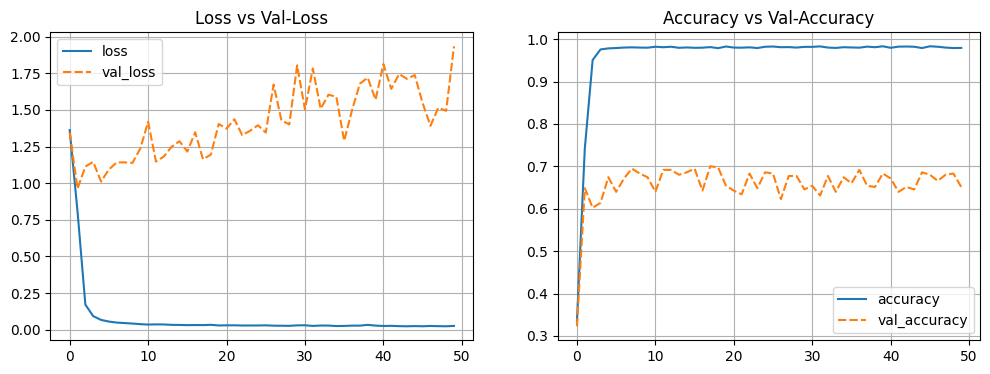

In [214]:
# Plot training results

history_functional_df = pd.DataFrame(history_functional.history)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_functional_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_functional_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

In [215]:
# Predict test-set

y_pred_functional = model_functional.predict(X_test_pad)

99/99 [==============================] - 1s 6ms/step


In [216]:
# Model Evaluation (test-set)

roc_auc_f = roc_auc_score(y_test_encoded, y_pred_functional, multi_class='ovr')
print("ROC-AUC Score:", roc_auc_f)

ROC-AUC Score: 0.8300259678389452


Insight : Pada skor `ROC-AUC`, cukup tinggi untuk `functional api training` yaitu sebesar `83%` jika dibulatkan. Kesimpulannya masih `bagus` `sequential api training`

# ANN Improvement (Sequential API/Functional API)

## Sequential API

In [217]:
# Clear session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [218]:
# Create callback
callback_2 = [
    EarlyStopping(monitor = 'val_loss',
                  patience = 20,
                  restore_best_weights=True)
]

### vi.1. Model Definition

In [219]:
# Create sequential API

model_sequential_ = Sequential()
model_sequential_.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=maxlen))
model_sequential_.add(Flatten())
model_sequential_.add(Dense(128,
                           activation='relu',
                           kernel_initializer=tf.keras.initializers.HeNormal(seed),
                           input_shape=(input_dim,)))
model_sequential_.add(Dense(256,
                           activation='relu',
                           kernel_initializer=tf.keras.initializers.HeNormal(seed)))
model_sequential_.add(Dense(num_classes,
                           activation='softmax',
                           kernel_initializer=tf.keras.initializers.GlorotNormal(seed)))

# Compile
model_sequential_.compile(loss='sparse_categorical_crossentropy',
                         optimizer='adam',
                         metrics=['accuracy'])
model_sequential_.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1122400   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 128)               1280128   
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 2436580 (9.29 MB)
Trainable params: 2436580 (9.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


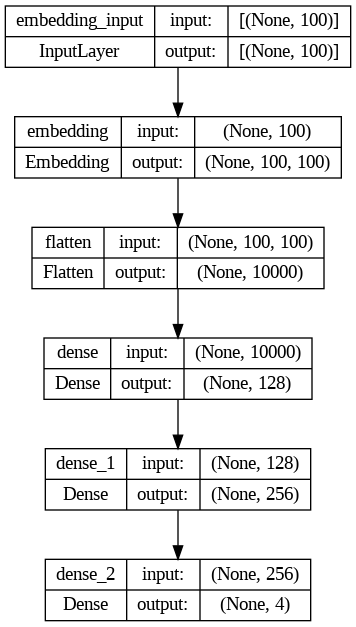

In [220]:
# Plot layers

tf.keras.utils.plot_model(model_sequential_, show_shapes=True)

### vi.2. Model Training

In [221]:
# Train the model

%%time
history_sequential_ = model_sequential_.fit(X_train_pad,
                                          y_train_encoded,
                                          epochs=60,
                                          callbacks=callback_2,
                                          validation_data=(X_val_pad, y_val_encoded),
                                          batch_size=64)

Epoch 1/60
57/57 [==============================] - 4s 61ms/step - loss: 1.3783 - accuracy: 0.3128 - val_loss: 1.3676 - val_accuracy: 0.3199
Epoch 2/60
57/57 [==============================] - 2s 39ms/step - loss: 0.9969 - accuracy: 0.6114 - val_loss: 0.9945 - val_accuracy: 0.6023
Epoch 3/60
57/57 [==============================] - 2s 39ms/step - loss: 0.1949 - accuracy: 0.9529 - val_loss: 0.9467 - val_accuracy: 0.6686
Epoch 4/60
57/57 [==============================] - 2s 40ms/step - loss: 0.0811 - accuracy: 0.9784 - val_loss: 0.9674 - val_accuracy: 0.6686
Epoch 5/60
57/57 [==============================] - 2s 41ms/step - loss: 0.0627 - accuracy: 0.9792 - val_loss: 0.8584 - val_accuracy: 0.7205
Epoch 6/60
57/57 [==============================] - 3s 54ms/step - loss: 0.0559 - accuracy: 0.9809 - val_loss: 0.9534 - val_accuracy: 0.6657
Epoch 7/60
57/57 [==============================] - 3s 45ms/step - loss: 0.0467 - accuracy: 0.9795 - val_loss: 0.8829 - val_accuracy: 0.7147
Epoch 8/60
57

### vi.3. Model Evaluation

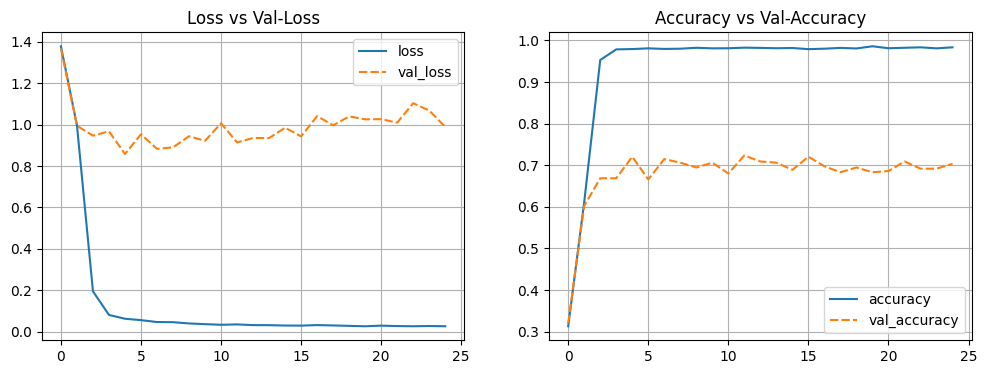

In [222]:
# Plot training results

history_sequential_df_ = pd.DataFrame(history_sequential_.history)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_sequential_df_[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_sequential_df_[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

In [223]:
# Predict test-set

y_pred_sequential_ = model_sequential_.predict(X_test_pad)

99/99 [==============================] - 1s 5ms/step


In [224]:
# Model Evaluation (test-set)

roc_auc_s_ = roc_auc_score(y_test_encoded, y_pred_sequential_, multi_class='ovr')
print("ROC-AUC Score:", roc_auc_s_)

ROC-AUC Score: 0.8674938109651621


Insight : Pada skor `ROC-AUC`, cukup tinggi untuk `functional api training` yaitu sebesar `87%` jika dibulatkan. Kesimpulannya masih `bagus` `sequential api training`

## Functional API

In [225]:
# Clear session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

### vi.1. Model Definition

In [226]:
input_layer_ = Input(shape=(maxlen,))
embedding_layer_ = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=maxlen)(input_layer_)
flatten_layer_ = Flatten()(embedding_layer_)
hidden_layer_1_ = Dense(256, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed)) (flatten_layer_)
hidden_layer_2_ = Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed)) (hidden_layer_1_)
hidden_layer_3_ = Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed)) (hidden_layer_2_)

concat_layer_ = concatenate([flatten_layer_, hidden_layer_3_])
output_layer_ = Dense(num_classes, activation='softmax') (concat_layer_)

model_functional_ = Model(inputs=input_layer_, outputs=output_layer_)

# Compile
model_functional_.compile(loss='sparse_categorical_crossentropy',
                         optimizer='adam',
                         metrics='accuracy')
model_functional_.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 100, 100)             1122400   ['input_1[0][0]']             
                                                                                                  
 flatten (Flatten)           (None, 10000)                0         ['embedding[0][0]']           
                                                                                                  
 dense (Dense)               (None, 256)                  2560256   ['flatten[0][0]']             
                                                                                              

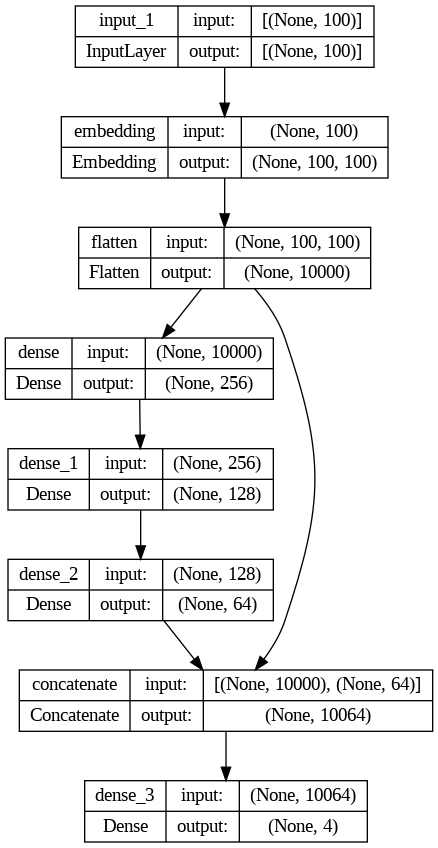

In [227]:
# Plot layers

tf.keras.utils.plot_model(model_functional_, show_shapes=True)

### vi.2. Model Training

In [228]:
# Train the model

%%time
history_functional_ = model_functional_.fit(X_train_pad,
                                          y_train_encoded,
                                          epochs=60,
                                          validation_data=(X_val_pad, y_val_encoded),
                                          batch_size=64)

Epoch 1/60
57/57 [==============================] - 5s 77ms/step - loss: 1.3699 - accuracy: 0.3216 - val_loss: 1.3671 - val_accuracy: 0.3228
Epoch 2/60
57/57 [==============================] - 4s 75ms/step - loss: 1.1118 - accuracy: 0.5873 - val_loss: 1.1012 - val_accuracy: 0.5476
Epoch 3/60
57/57 [==============================] - 4s 64ms/step - loss: 0.2694 - accuracy: 0.9291 - val_loss: 1.1270 - val_accuracy: 0.6167
Epoch 4/60
57/57 [==============================] - 4s 67ms/step - loss: 0.0980 - accuracy: 0.9748 - val_loss: 1.1231 - val_accuracy: 0.6340
Epoch 5/60
57/57 [==============================] - 5s 79ms/step - loss: 0.0612 - accuracy: 0.9792 - val_loss: 1.1240 - val_accuracy: 0.6254
Epoch 6/60
57/57 [==============================] - 4s 65ms/step - loss: 0.0498 - accuracy: 0.9820 - val_loss: 1.0459 - val_accuracy: 0.6715
Epoch 7/60
57/57 [==============================] - 4s 64ms/step - loss: 0.0407 - accuracy: 0.9809 - val_loss: 1.1606 - val_accuracy: 0.6513
Epoch 8/60
57

### vi.3. Model Evaluation

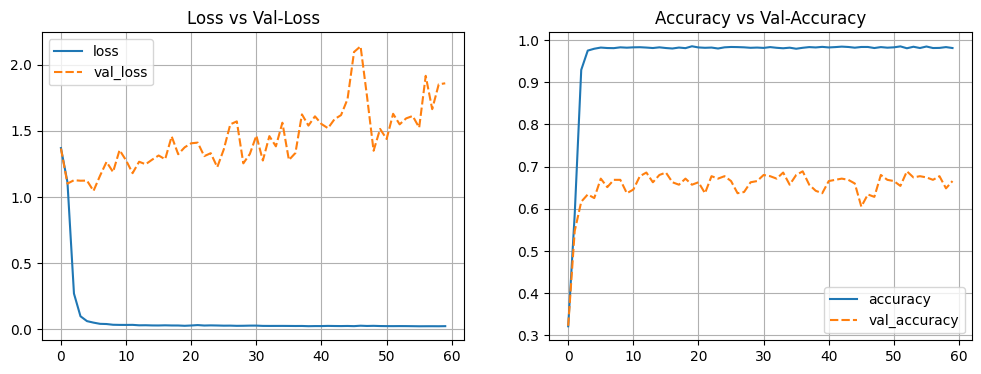

In [229]:
# Plot training results

history_functional_df_ = pd.DataFrame(history_functional_.history)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_functional_df_[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_functional_df_[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

In [230]:
# Predict test-set

y_pred_functional_ = model_functional_.predict(X_test_pad)

99/99 [==============================] - 1s 8ms/step


In [231]:
# Model Evaluation (test-set)

roc_auc_f_ = roc_auc_score(y_test_encoded, y_pred_functional_, multi_class='ovr')
print("ROC-AUC Score:", roc_auc_f_)

ROC-AUC Score: 0.8464689914059809


Insight : Pada skor `ROC-AUC`, cukup tinggi untuk `functional api training` yaitu sebesar `85%` jika dibulatkan. Kesimpulannya masih `bagus` `sequential api training`

# Model Saving

In [243]:
# Save tokenizer

import pickle
with open('tokenizer.pkl', 'wb') as file_1:
  pickle.dump(tokenizer, file_1)

In [237]:
# Model summary

model_sequential_.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1122400   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 128)               1280128   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
Total params: 2411044 (9.20 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 2411044 (9.20 MB)
_________________________________________________________________


In [239]:
# Save ANN Model

model_sequential_.save('model.keras')

# Model Inference

On notebook : `inference.ipynb`

# Pengambilan Kesimpulan

Kesimpulannya adalah bahwa melakukan training pada NLP dengan ANN model harus selalu melakukan uji coba secara terus menerus dengan mengganti parameter dan dilakukan evaluasi demi mencapai skor prediksi yang semakin bagus.